# Quantum circuit Born machine
## Experiment 1: Non-differentiable learning

In this notebook the quantum circuit born machine with non-differentiable learning is implemented and tested by learning and subsequently reproducing the a simple probability distribution.
For a complete reference of the implementation and explanation of the related theory see the main text of the project. For a complex application of this implementation see the notebook
ending in suffix Real instead of Basic.

Note that this code does not perform checks for validity of the input, for this reason the code should be reused with caution.

In [2]:
# Imports

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Sampler, BackendSampler
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.noise import NoiseModel
from qiskit.utils import algorithm_globals
from qiskit_algorithms.optimizers import ADAM, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_ibm_runtime import Sampler as IBMSampler
from qiskit_ibm_runtime import Session, Options, QiskitRuntimeService
from qiskit_ibm_runtime.options import TranspilationOptions

from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

import numpy as np
import time
from scipy.stats import norm
from scipy.optimize import minimize

# Import pandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.auto import tqdm
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "serif"

In [2]:
use_ibm_sim = False
use_ibm_q = False

In [3]:
if use_ibm_sim or use_ibm_q:
    service = QiskitRuntimeService()

In [4]:
if use_ibm_sim:
    backend = 'simulator_statevector'
elif use_ibm_q:
    #backend = service.least_busy(simulator=False, operational=True)
    backend = service.get_backend('ibmq_mumbai')
else:
    from qiskit.providers.fake_provider import FakeMumbaiV2
    backend = FakeMumbaiV2()
backend

In [5]:
if use_ibm_q:
    options = Options(optimization_level=3, transpilation=TranspilationOptions(skip_transpilation=True))

In [6]:
# Global setup

num_qubits = 12
num_discrete_values = 2**num_qubits
shots = 1000

algorithm_globals.random_seed = 123456

In [7]:
num_discrete_values

4096

In [8]:
# Helper functions

def rbf_kernel(x, y, sigma_list):
    exponent = np.abs(x[:, None] - y[None, :])**2
    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma)
        K = K + np.exp(-gamma * exponent)
    return K

class mmd:
    def __init__(self, sigma_list, basis, kernel):
        self.sigma_list = sigma_list
        self.basis = basis
        self.kernel=kernel
        self.K = self.kernel(basis, basis, self.sigma_list)

    def calc(self, px, py):
        pxy = px-py
        return self.kernel_expect(pxy, pxy)

    def kernel_expect(self, px, py):
        return px.dot(self.K).dot(py)

def dist(sampler, circuit, parameters):
    job = sampler.run(circuits=circuit, parameter_values=parameters)
    result = job.result()
    quasi_dist = result.quasi_dists[0]
    prob_dist = quasi_dist.nearest_probability_distribution()
    return prob_dist

def dist_pdf(dist):
    prob = []
    maximmum = int(num_qubits * '1', 2) + 1
    for key in range(0, maximmum):
        value = dist.get(key)
        if value:
            prob.append(value)
        else:
            prob.append(0)
    return np.array(prob)

def pd_process(data_df):
    res_proc = pd.DataFrame({'mean': data_df.mean(axis = 1),\
                           'std': data_df.std(axis = 1),\
                           'sem': data_df.sem(axis = 1)})
    return res_proc

In [9]:
# QCBM circuit
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
qc.h(qc.qubits)
ansatz = EfficientSU2(num_qubits, entanglement='circular', reps=2)
qc.compose(ansatz, inplace=True)
qc.measure_all()

In [10]:
l = Layout.from_intlist([1,4,7,10,12,13,14,11,8,5,3,2], qr)

In [11]:
if not(use_ibm_sim):
    noise_model = NoiseModel.from_backend(backend)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3, layout_method='sabre', initial_layout=l)
    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(durations=target.durations()),
            PadDynamicalDecoupling(
                durations=target.durations(),
                dd_sequences=[XGate(), XGate()],
                pulse_alignment=target.pulse_alignment,
            ),
        ]
    )

In [12]:
if not(use_ibm_sim):
    qc_transpiled = pm.run(qc)

In [13]:
print(qc.num_parameters)
print(qc_transpiled.depth())

72
46


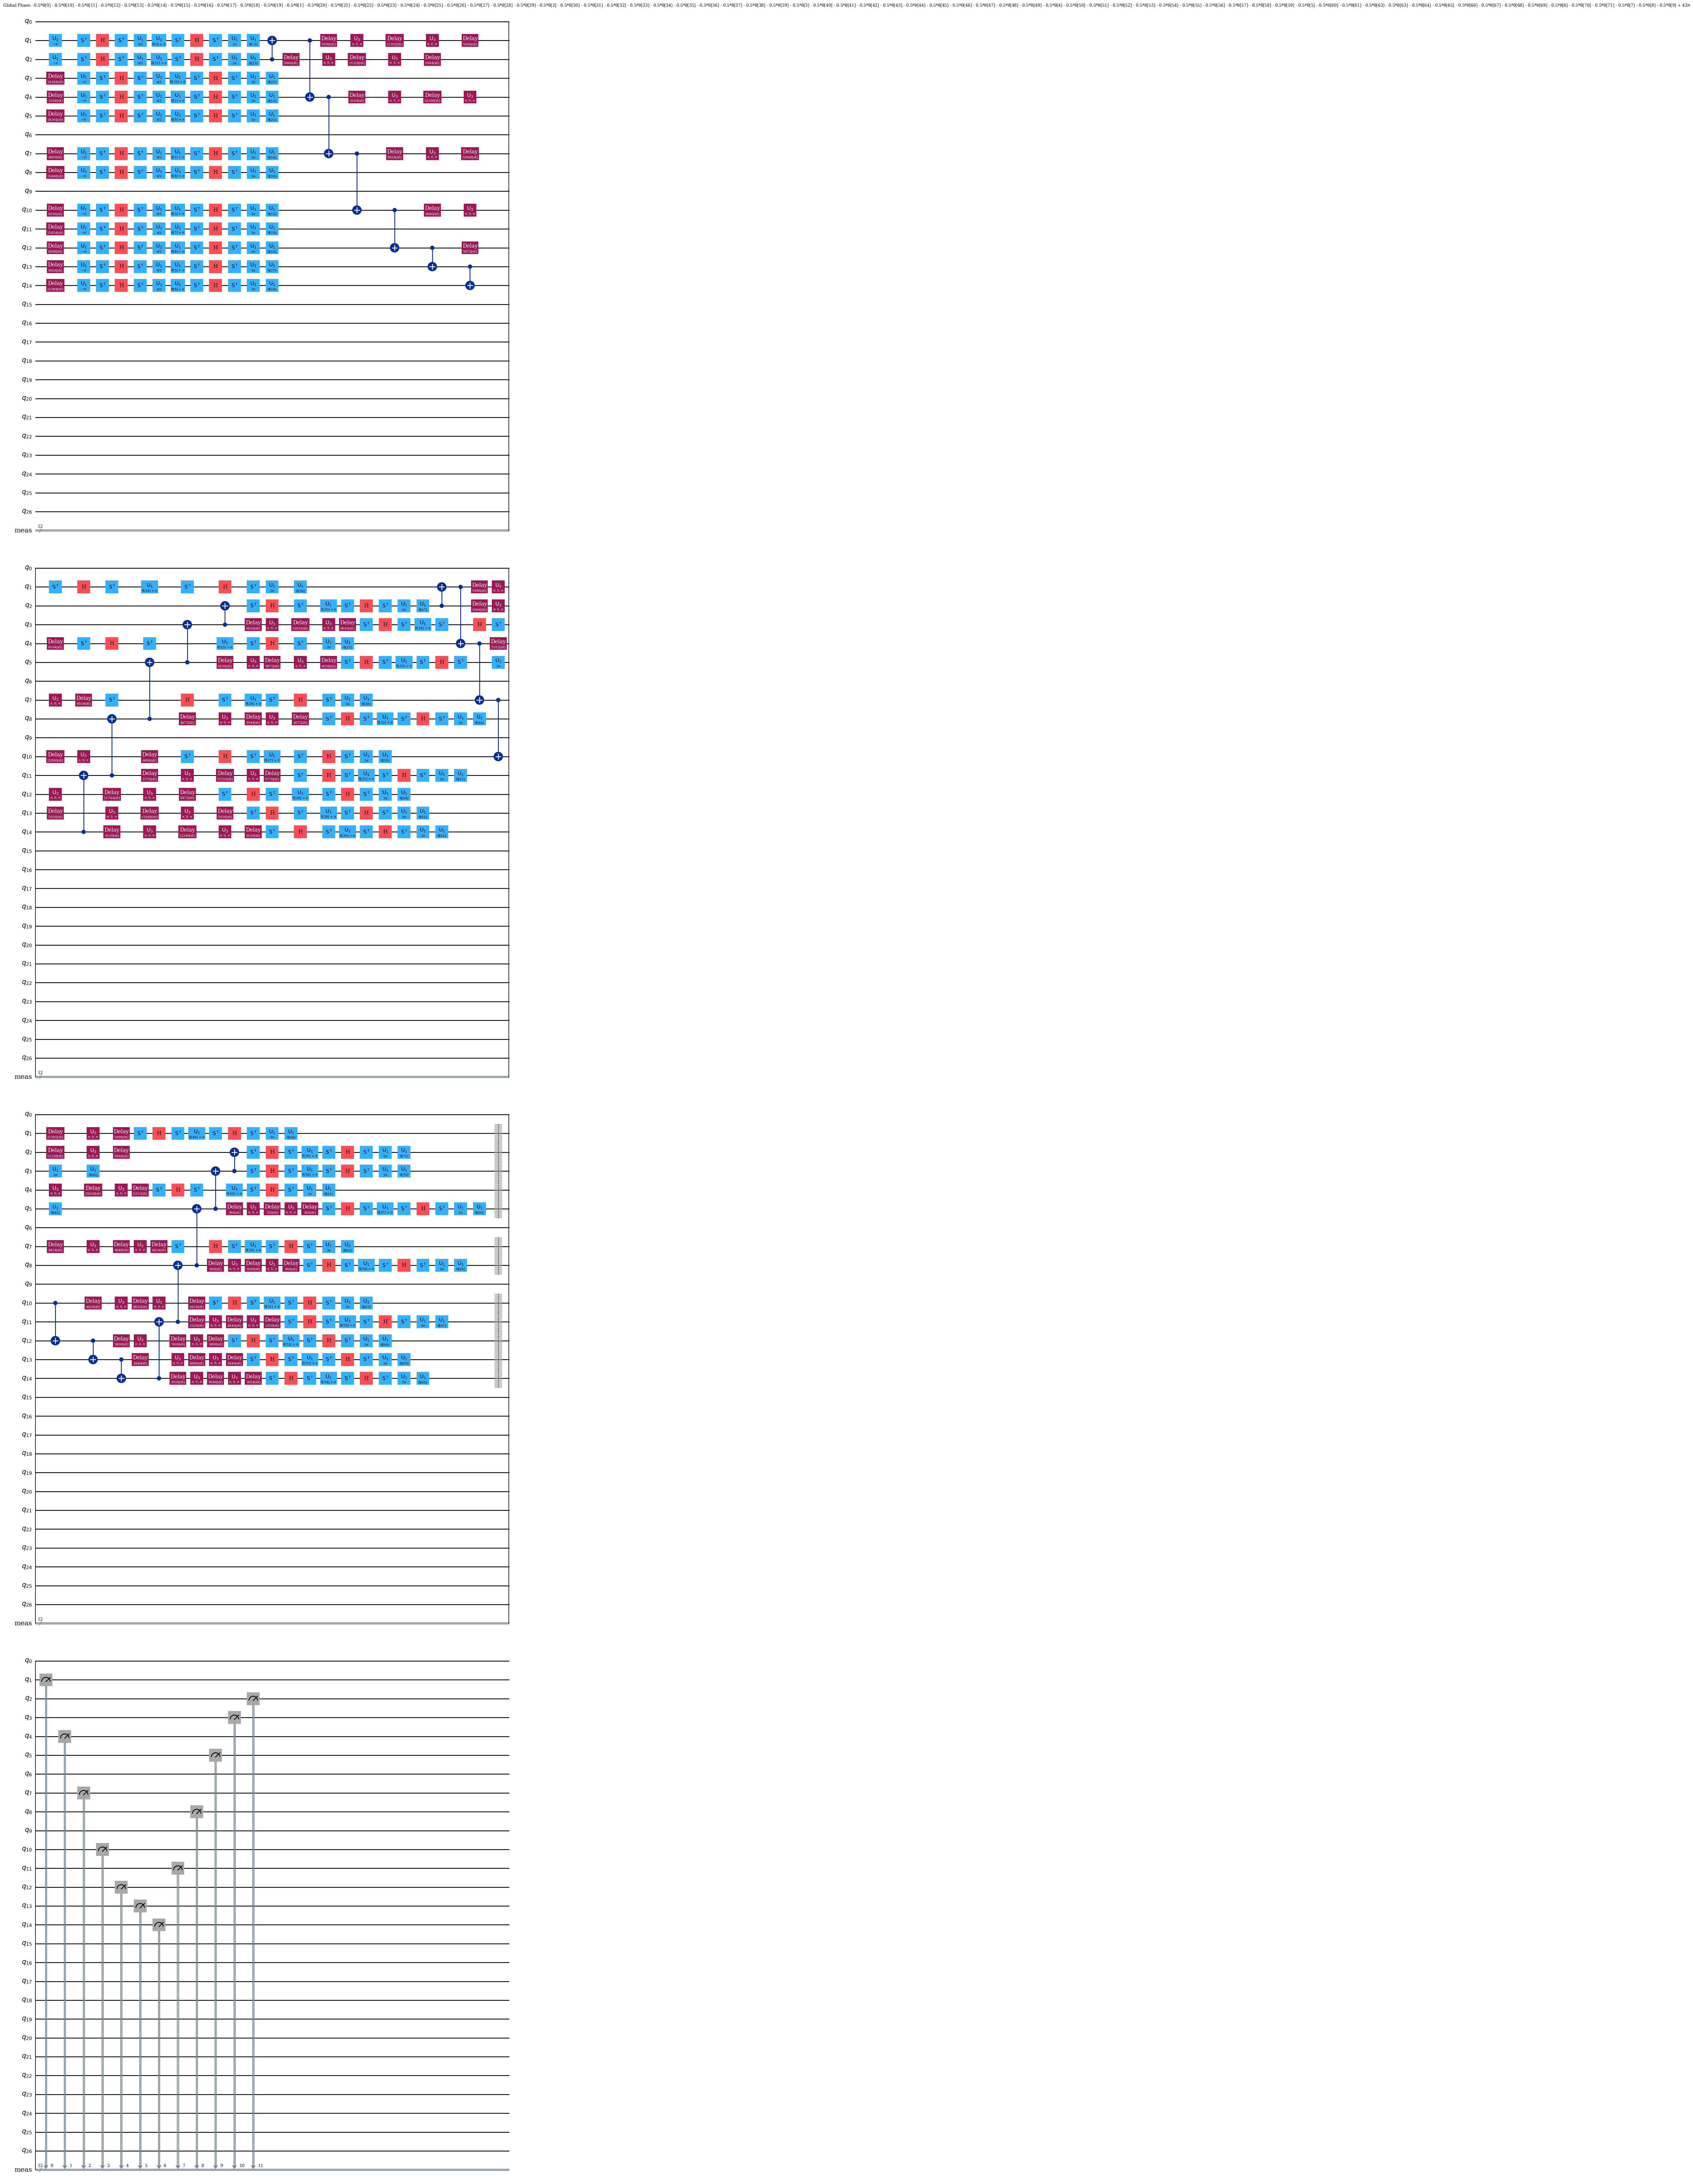

In [14]:
#qc.decompose().draw('mpl', style='iqp', filename = 'circuit.pdf')
qc_transpiled.decompose().draw('mpl', style='iqp', filename = 'transpiled_circuit.pdf')

In [15]:
def get_cost_tv(p_data, sampler, circuit, shots, history):
    def cost_tv_fun(parameters):
        if shots == None:
            # For use with Sampler()
            prob = dist_pdf(dist(sampler, circuit, parameters))
        else:
            # For use with everything else
            prob = dist_pdf(sampler.run(circuits=circuit, parameter_values=parameters, shots = shots).result().quasi_dists[0].nearest_probability_distribution())
        cost = np.sum(np.abs(prob-p_data)**2)
        if history != None:
            history.append(cost)
        return cost
    return cost_tv_fun

In [16]:
def get_cost_mmd(p_data, mmd, sampler, circuit, shots, history):
    def cost_mmd_fun(parameters):
        if shots == None:
            # For use with Sampler()
            prob = dist_pdf(dist(sampler, circuit, parameters))
        else:
            # For use with everything else
            prob = dist_pdf(sampler.run(circuits=circuit, parameter_values=parameters, shots = shots).result().quasi_dists[0].nearest_probability_distribution())
        cost = self.mmd.calc(prob, self.p_data)
        if history != None:
            history.append(cost)
        return cost
    return cost_mmd_fun

In [17]:
def get_gradient_analytic(p_data, mmd, sampler, circuit, shots, history_cost, history_grad):
    def gradient_analytic(parameters):
        num_of_par = len(parameters)
        circuits_list = [circuit] * (2 * num_of_par + 1) 
        parameters_list = []
        gradient = []
        parameters_list.append(parameters.copy())
        for i in range(num_of_par):
            # pi/2 phase
            pars_plus = parameters.copy()
            pars_plus[i] += np.pi/2
            parameters_list.append(pars_plus)
            # -pi/2 phase
            pars_minus = parameters.copy()
            pars_minus[i] -= np.pi/2
            parameters_list.append(pars_minus)
        if shots == None:
            jobs = sampler.run(circuits=circuits_list, parameter_values=parameters_list)
        else:
            jobs = sampler.run(circuits=circuits_list, parameter_values=parameters_list, shots = shots)
        results = jobs.result()
        pd_list = []
        for qd in results.quasi_dists:
            pd_list.append(dist_pdf(qd.nearest_probability_distribution()))
        prob = pd_list[0]
        for i in range(1, 2 * num_of_par + 1, 2):
            prob_plus = pd_list[i]
            prob_minus = pd_list[i + 1]
            grad_plus = mmd.kernel_expect(prob, prob_plus) - mmd.kernel_expect(prob, prob_minus)
            grad_minus = mmd.kernel_expect(self.p_data, prob_plus) - mmd.kernel_expect(self.p_data, prob_minus)
            gradient.append(grad_plus - grad_minus)
        if history_cost != None:
            history_cost.append(prob)
        if history_grad != None:
            history_grad.append(gradient)
        return np.array(gradient)
    return gradient_analytic

In [18]:
# Prepare data
coords = np.linspace(-4, 4, num_discrete_values)
normal = norm(loc=0.0, scale=1)
#prob_data = normal.pdf(coords)
prob_data = 0.4 * norm(loc=-3, scale=0.3).pdf(coords) + 0.3 * norm(loc=1, scale=0.3).pdf(coords) + 0.2 * norm(loc=3, scale=0.6).pdf(coords) + 0.1 * norm(loc=-1, scale=0.6).pdf(coords)
prob_data = prob_data / np.sum(prob_data)

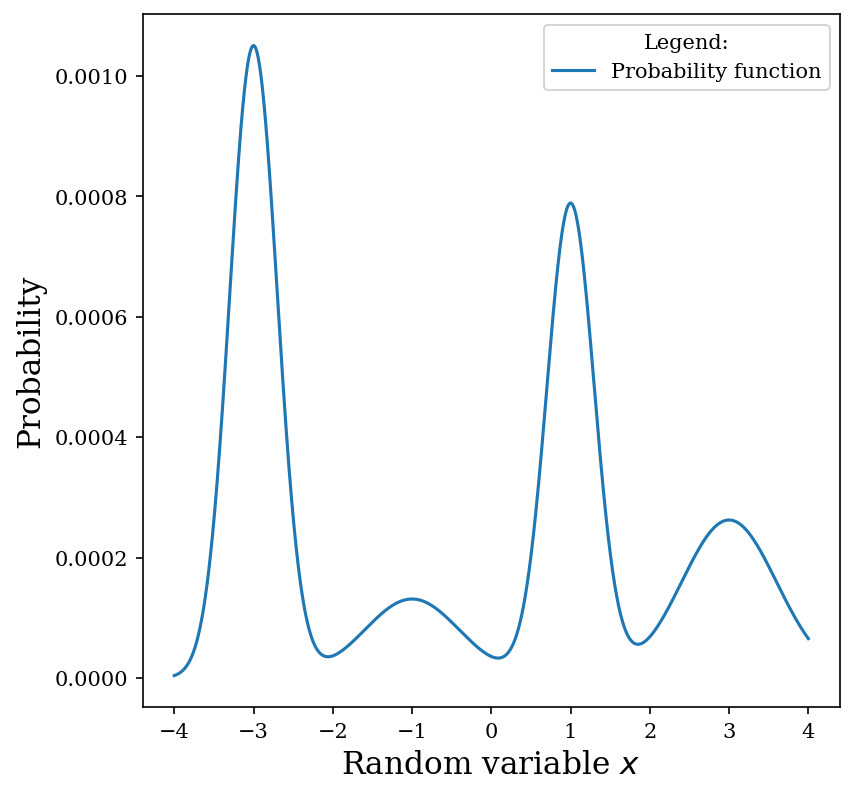

In [19]:
# Visualize data
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.plot(coords, prob_data, label = 'Probability function')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-prob_data.pdf', format='pdf')
plt.show()

In [20]:
MMD = mmd(sigma_list=[0.4,8], basis=np.arange(2**num_qubits), kernel=rbf_kernel)

In [21]:
def build_callback(callback_dict):
    def callback(current_vector):
        callback_dict["iters"] += 1
        callback_dict["tqdm"].update(1)
        callback_dict["par_hist"].append(current_vector)
    return callback

In [22]:
# COBYLA training
def train_cobyla(init_params = None, circuit = None, max_iter = 1000, ibm = False, shots = None):
    t = tqdm(total=max_iter)
    callback_dict = {
        "iters": 0,
        "tqdm": t,
        "par_hist" : []
    }
    cost_history = []
    callback = build_callback(callback_dict)
    #optimizer = COBYLA(maxiter = max_iter, tol=1e-8, rhobeg=1.0)
    if init_params == None:
        parameters = np.zeros(circuit.num_parameters)
    elif init_params == 'rand':
        parameters = np.random.rand(circuit.num_parameters) * np.pi
    else:
        parameters = init_params
    if ibm:
        with Session(service, backend=backend) as session:
            ibmsampler = IBMSampler(session=session, options=options)
            cost_fun = get_cost_tv(prob_data, ibmsampler, circuit.copy(), shots, cost_history)
            optimizer_result = minimize(
                fun = cost_fun,
                x0 = parameters,
                method="cobyla",
                callback=callback,
                bounds = [(-np.pi,np.pi) for a in range(len(parameters))],
                tol = 1e-8,
                options = {'maxiter' : max_iter, 'rhobeg' : 1.0}
            )
            session.cancel()
            #optimizer_result = optimizer.minimize(fun = cost_fun, x0 = parameters, bounds = [(-np.pi,np.pi) for a in range(len(parameters))]) 
    else:
        cost_fun = get_cost_tv(prob_data, local_sampler, circuit.copy(), shots, cost_history)
        optimizer_result = minimize(
            fun = cost_fun,
            x0 = parameters,
            method="cobyla",
            callback=callback,
            bounds = [(-np.pi,np.pi) for a in range(len(parameters))],
            tol = 1e-8,
            options = {'maxiter' : max_iter, 'rhobeg' : 1.0}
        )
        #optimizer_result = optimizer.minimize(fun = cost_fun, x0 = parameters, bounds = [(-np.pi,np.pi) for a in range(len(parameters))]) 
    t.close()
    return optimizer_result, cost_history, callback_dict

In [23]:
def bin_mean(data, bin_size):
    if (len(data)%bin_size):
        raise ValueError
    bin_data = []
    for i in range(0, len(data), bin_size):
        bin_data.append(np.mean(data[i:i+bin_size]))
    return bin_data

## Find Optimal Depth

In [24]:
local_sampler = AerSampler(
    backend_options={'noise_model' : noise_model,
                     "seed_simulator": algorithm_globals.random_seed,
                     "method": 'density_matrix',
                     "device": "CPU",
                     #"batched_shots_gpu": True
                    },
    skip_transpilation = True)

In [25]:
from qiskit_ibm_runtime.options import SimulatorOptions, TranspilationOptions

In [26]:
sim_options = Options(transpilation=TranspilationOptions(skip_transpilation=True), simulator=SimulatorOptions(noise_model=noise_model))
#sim_options = Options(transpilation=TranspilationOptions(skip_transpilation=True))

In [ ]:
depth_cobyla_x = []
depth_cobyla_fun = []
depth_cobyla_nfev = []
for depth in tqdm(range(7,11)):
    dqr = QuantumRegister(num_qubits)
    dqc = QuantumCircuit(qr)
    dqc.h(dqc.qubits)
    dansatz = EfficientSU2(num_qubits, entanglement='circular', reps=depth)
    dqc.compose(dansatz, inplace=True)
    dqc.measure_all()
    dqc_transpiled = pm.run(dqc)
    dres_cobyla, dhist_cobyla, dcallback_cobyla = train_cobyla(max_iter=1000, circuit=dqc_transpiled.copy(), ibm = False, shots = 4000)
    depth_cobyla_x.append(dres_cobyla.x)
    depth_cobyla_fun.append(dres_cobyla.fun)
    depth_cobyla_nfev.append(dres_cobyla.nfev)
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-x.txt', dres_cobyla.x)
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-fun.txt', [dres_cobyla.fun])
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-nfev.txt', [dres_cobyla.nfev])
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-iters.txt', [dcallback_cobyla['iters']])
    np.savetxt('RP01E1OD-cobylaD'+str(depth)+'-par_hist.txt', dcallback_cobyla['par_hist'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method cobyla cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
np.savetxt('RP01E1OD-cobylaD-nfev.txt', depth_cobyla_nfev)
np.savetxt('RP01E1OD-cobylaD-fun.txt', depth_cobyla_fun)
np.savetxt('RP01E1OD-cobylaD-x.txt', depth_cobyla_x)

In [3]:
# Load from textfiles
opt_depth_fun = []
opt_depth_nfev = []
for depth in range(1, 8+1):
    opt_depth_fun.append(np.loadtxt('RP01E1OD-cobylaD'+str(depth)+'-fun.txt'))
    opt_depth_nfev.append(np.loadtxt('RP01E1OD-cobylaD'+str(depth)+'-nfev.txt'))

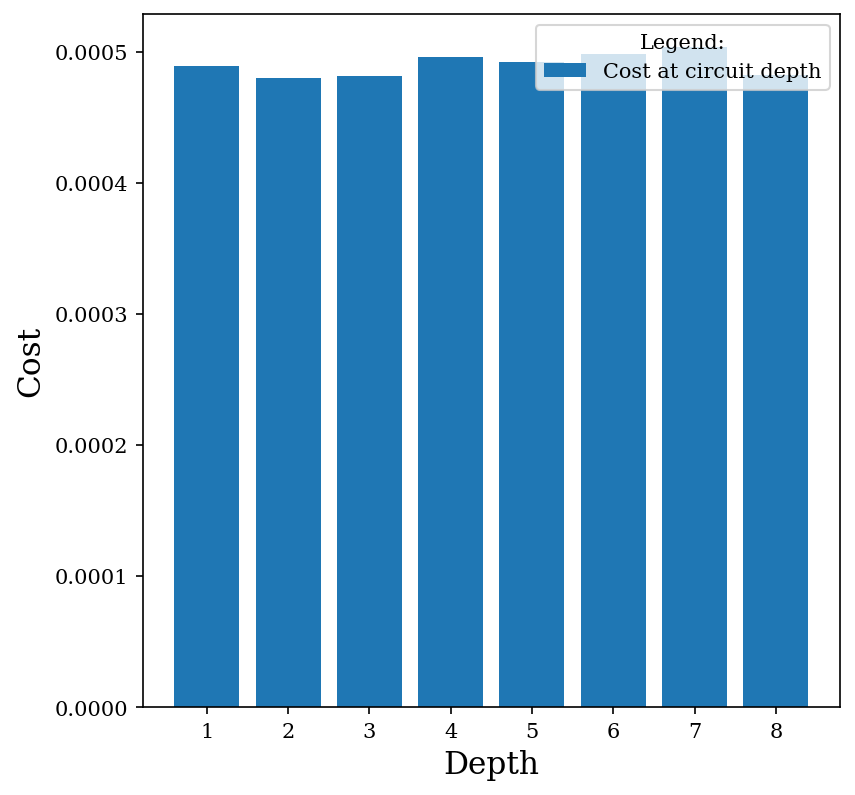

In [5]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(range(1,len(opt_depth_fun)+1), opt_depth_fun, label='Cost at circuit depth')
#ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Depth', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-depth_costFULL.pdf', format='pdf', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(range(1,len(depth_cobyla_fun)+1), depth_cobyla_fun, label='model trained with COBYLA')
#ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Depth', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-depth_cost.pdf', format='pdf')
plt.show()

## Train with COBYLA

In [25]:
ch = []
with Session(service, backend='ibmq_qasm_simulator') as session:
    ibmsampler = IBMSampler(session=session, options=sim_options)
    cost_fun = get_cost_tv(prob_data, ibmsampler, qc_transpiled.copy(), 1000, ch)
    start = time.time()
    cost_fun(np.zeros(qc_transpiled.num_parameters))
    end = time.time()
    session.cancel()

base_primitive._run_primitive:INFO:2024-01-27 21:21:35,772: Submitting job using options {'optimization_level': 3, 'resilience_level': 1, 'transpilation': {'skip_transpilation': True, 'optimization_settings': {'level': 3}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 1}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': <NoiseModel on ['sx', 'x', 'measure', 'id', 'cx', 'reset']>, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {'noise_model': <NoiseModel on ['sx', 'x', 'measure', 'id', 'cx', 'reset']>}}


In [26]:
ch

[0.001273855101371713]

In [ ]:
res_cobyla, hist_cobyla, callback_cobyla = train_cobyla(max_iter=300, circuit=qc_transpiled, ibm = False, shots = 1000)

In [101]:
# Save data
if False:
    np.savetxt('RP01E1OD-cobyla-x.txt', res_cobyla.x)
    np.savetxt('RP01E1OD-cobyla-fun.txt', [res_cobyla.fun])
    np.savetxt('RP01E1OD-cobyla-nfev.txt', [res_cobyla.nfev])
    np.savetxt('RP01E1OD-cobyla-iters.txt', [callback_cobyla['iters']])
    np.savetxt('RP01E1OD-cobyla-par_hist.txt', callback_cobyla['par_hist'])

In [ ]:
pdf_cobyla = dist_pdf(pdf_sampler.run(circuits=qc_transpiled, parameter_values=res_cobyla.x, shots = 8000).result().quasi_dists[0].nearest_probability_distribution())

In [ ]:
pdf_cobyla = dist_pdf(dist(pdf_sampler, qc.copy(), res_cobyla.x))

In [ ]:
bin_pdf_cobyla = bin_mean(pdf_cobyla, 64)

In [ ]:
bin_prob_data = bin_mean(prob_data, 64)

In [ ]:
bin_coords = bin_mean(coords, 64)

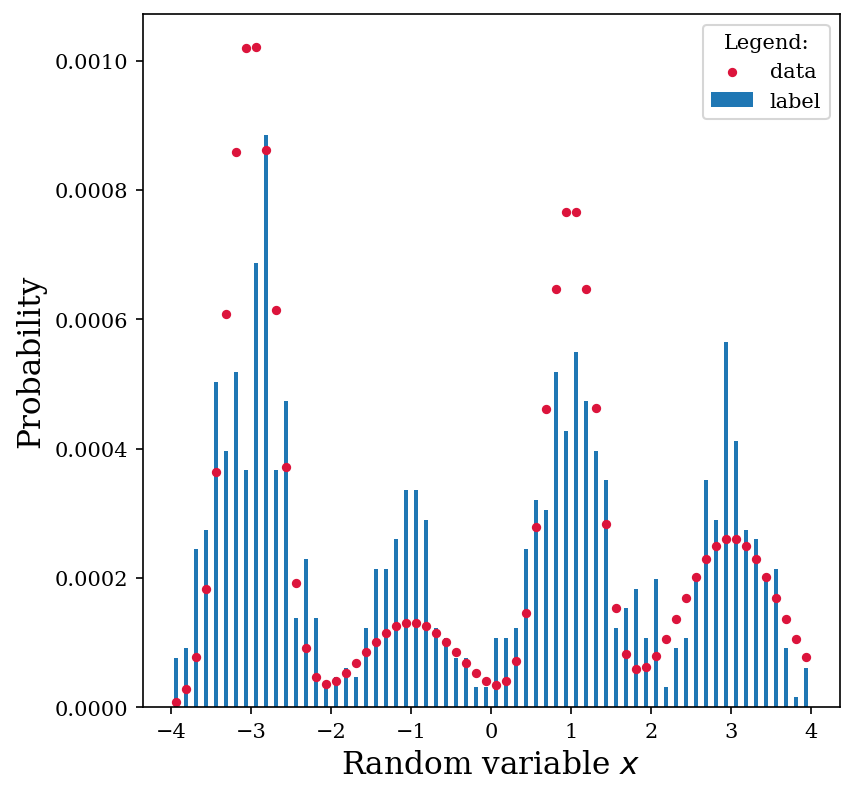

In [96]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.bar(bin_coords, bin_pdf_cobyla, width=0.05, label='model trained with COBYLA')
ax.scatter(bin_coords, bin_prob_data, color='crimson', s=12, label='data')
ax.set_ylabel(r'Probability', fontsize=15)
ax.set_xlabel(r'Random variable $x$', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-model_and_data.pdf', format='pdf')
plt.show()

In [62]:
print(res_cobyla.x)
print(res_cobyla.nfev)
print(res_cobyla.fun)

[-1.31215127e-02  4.81110622e-04  3.96378281e-03  1.95057849e-02
  6.17618708e-03  4.02212464e-03  4.52077923e-02  9.58092492e-02
 -2.35060367e-02 -1.38286427e-02  1.62967173e-01 -1.74072071e-01
 -3.54285181e-04 -2.57920169e-01  1.44433810e-02  4.47757968e-02
  1.08310272e-02  2.01561797e-02  5.54729188e-02 -1.25248166e-02
  2.62755601e-02  1.94359772e-02 -4.46395937e-03 -2.45846972e-02
 -3.14841805e-03 -4.02862810e-02 -2.86644337e-02 -8.00094090e-03
 -3.73519885e-03 -1.41828950e-02 -2.57505638e-02  3.02478307e-02
 -3.91299061e-02  1.01177781e+00  9.09069031e-02 -2.52274700e-02
  6.29409970e-02  2.42963762e-04  2.09239987e-04  4.59961056e-04
  1.97593323e-04 -1.07141923e-02  3.33242372e-04  4.47561103e-04
  1.14880549e-02 -1.94550571e-04 -6.43787690e-04 -1.68261966e-03
 -8.74254649e-04  7.50242070e-02 -3.53281867e-02  3.98612507e-03
 -4.57029861e-03  1.16400879e-03  9.59566875e-02 -4.12296595e-02
 -6.51268603e-04  3.55353279e-02 -3.36174397e-02 -1.23788705e-02
  2.84474746e-02 -7.90847

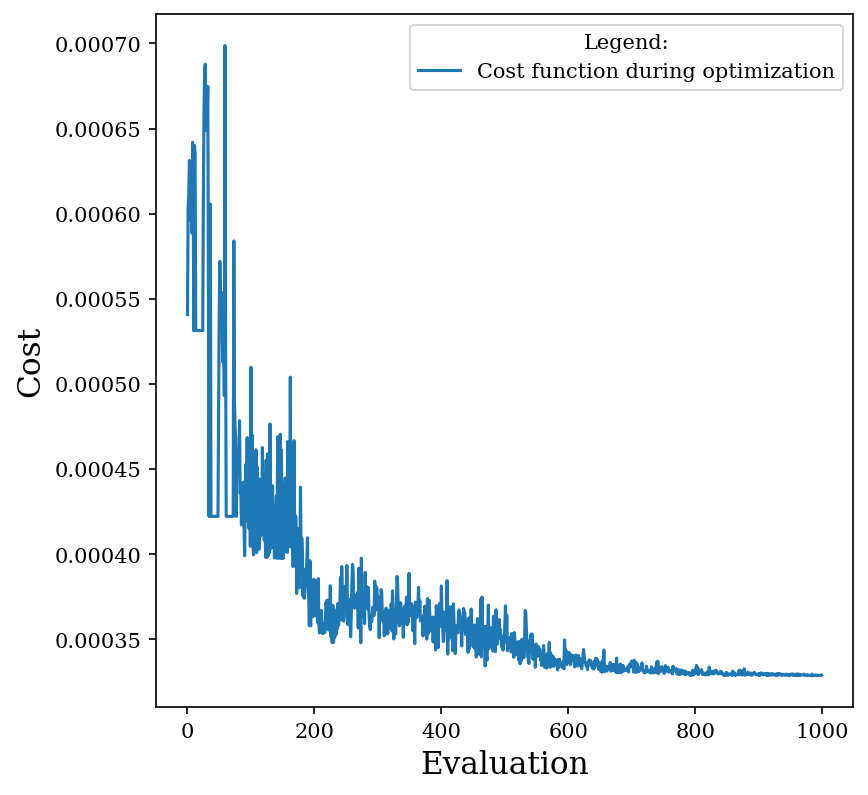

In [106]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(res_cobyla.nfev), hist_cobyla, label = 'Cost function during optimization')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Evaluation', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-cost_evaluation.pdf', format='pdf')

In [108]:
cost_history = []
cost_sampler = Sampler()
cost_tv_fun = get_cost_tv(prob_data, cost_sampler, qc, None, cost_history)
for par in tqdm(callback_cobyla['par_hist']):
    cost_tv_fun(par)

  0%|          | 0/1001 [00:00<?, ?it/s]

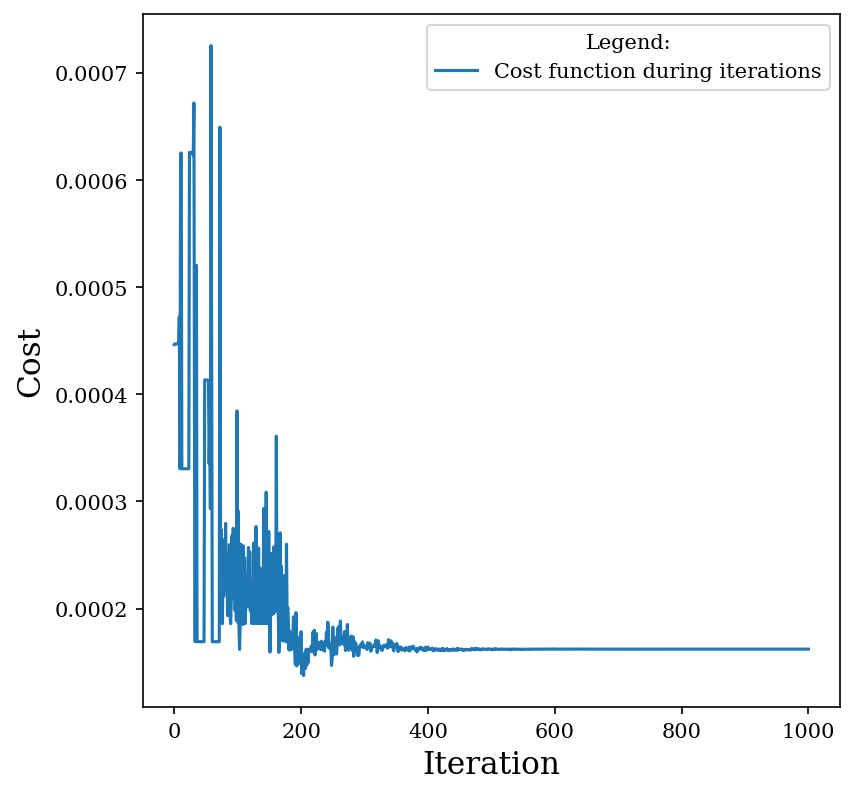

In [110]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
plot = ax.plot(range(len(cost_history)), cost_history, label = 'Cost function during iterations')
ax.set_ylabel(r'Cost', fontsize=15)
ax.set_xlabel(r'Iteration', fontsize=15)
plt.legend(title='Legend:')
plt.savefig('RP01-QCBM-E1-cost_iterations.pdf', format='pdf')